In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import pickle
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from helpers import helpers_functions

c:\Users\MEHMET\Desktop\stock_forecast\stenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv("datasets/tsla_data.csv")
df = df.sort_values("date").reset_index(drop=True)
df = df[["date","close"]]
df.rename(columns={"date":"ds","close":"y"}, inplace=True)
df.head()

,ds,y
0,2019-08-19,15.12
1,2019-08-20,15.06
2,2019-08-21,14.72
3,2019-08-22,14.81
4,2019-08-23,14.09


In [3]:
model = Prophet()

model.fit(df)

16:03:06 - cmdstanpy - INFO - Chain [1] start processing
16:03:06 - cmdstanpy - INFO - Chain [1] done processing


In [4]:
future = model.make_future_dataframe(periods=0)

forecast = model.predict(future)

In [5]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-08-19,-12.730962,-43.385258,29.391723,-12.730962,-12.730962,5.095674,5.095674,5.095674,-4.591260,-4.591260,-4.591260,9.686933,9.686933,9.686933,0.0,0.0,0.0,-7.635289
1,2019-08-20,-12.387262,-43.815384,26.965848,-12.387262,-12.387262,4.873127,4.873127,4.873127,-5.336020,-5.336020,-5.336020,10.209147,10.209147,10.209147,0.0,0.0,0.0,-7.514136
2,2019-08-21,-12.043562,-42.716166,31.831126,-12.043562,-12.043562,5.579378,5.579378,5.579378,-5.144547,-5.144547,-5.144547,10.723924,10.723924,10.723924,0.0,0.0,0.0,-6.464184
3,2019-08-22,-11.699862,-41.628293,30.151460,-11.699862,-11.699862,5.018841,5.018841,5.018841,-6.210914,-6.210914,-6.210914,11.229756,11.229756,11.229756,0.0,0.0,0.0,-6.681021
4,2019-08-23,-11.356162,-44.158974,30.148751,-11.356162,-11.356162,5.099642,5.099642,5.099642,-6.626587,-6.626587,-6.626587,11.726229,11.726229,11.726229,0.0,0.0,0.0,-6.256520


In [6]:
forecast.sort_values("ds", inplace=True)

In [7]:
df["trend"] = forecast["trend"]
df["additive_terms"] = forecast["additive_terms"]
df["weekly"] = forecast["weekly"]
df["yearly"] = forecast["yearly"]

In [8]:
df.head()

,ds,y,trend,additive_terms,weekly,yearly
0,2019-08-19,15.12,-12.730962,5.095674,-4.591260,9.686933
1,2019-08-20,15.06,-12.387262,4.873127,-5.336020,10.209147
2,2019-08-21,14.72,-12.043562,5.579378,-5.144547,10.723924
3,2019-08-22,14.81,-11.699862,5.018841,-6.210914,11.229756
4,2019-08-23,14.09,-11.356162,5.099642,-6.626587,11.726229


In [9]:
df.set_index("ds", inplace=True)
df.head()

,y,trend,additive_terms,weekly,yearly
ds,,,,,
2019-08-19,15.12,-12.730962,5.095674,-4.591260,9.686933
2019-08-20,15.06,-12.387262,4.873127,-5.336020,10.209147
2019-08-21,14.72,-12.043562,5.579378,-5.144547,10.723924
2019-08-22,14.81,-11.699862,5.018841,-6.210914,11.229756
2019-08-23,14.09,-11.356162,5.099642,-6.626587,11.726229


In [10]:
lags = np.arange(1,6)


In [11]:
df = helpers_functions.lag_features(df, lags, "y")

In [12]:
df.head()

,y,trend,additive_terms,weekly,yearly,lag_1,lag_2,lag_3,lag_4,lag_5
ds,,,,,,,,,,
2019-08-19,15.12,-12.730962,5.095674,-4.591260,9.686933,NaN,NaN,NaN,NaN,NaN
2019-08-20,15.06,-12.387262,4.873127,-5.336020,10.209147,15.12,NaN,NaN,NaN,NaN
2019-08-21,14.72,-12.043562,5.579378,-5.144547,10.723924,15.06,15.12,NaN,NaN,NaN
2019-08-22,14.81,-11.699862,5.018841,-6.210914,11.229756,14.72,15.06,15.12,NaN,NaN
2019-08-23,14.09,-11.356162,5.099642,-6.626587,11.726229,14.81,14.72,15.06,15.12,NaN


In [13]:
train_size = int(len(df) * 0.8)

train, val = df[:train_size], df[train_size:]

In [14]:
train_X = df.drop(columns="y")
train_y = df["y"]

val_X = df.drop(columns="y")
val_y = df["y"]

In [15]:
lgbm_model = LGBMRegressor()

lgbm_model.fit(train_X, train_y)

pred_y = lgbm_model.predict(val_X)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 1257, number of used features: 9
[LightGBM] [Info] Start training from score 193.070692


In [16]:
print(mean_absolute_error(val_y, pred_y))
print(mean_squared_error(val_y, pred_y))

2.735453733357443
15.458951320322177


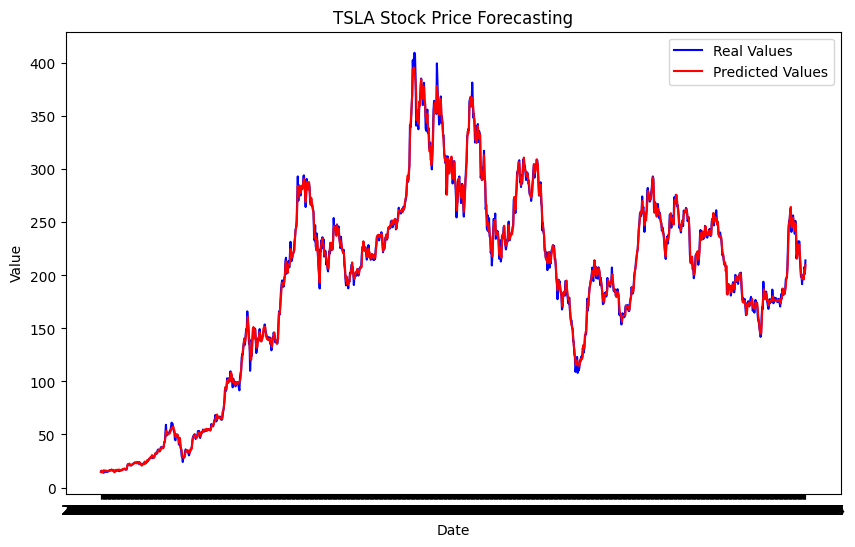

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['y'], label='Real Values', color='blue')
plt.plot(val_X.index, pred_y, label='Predicted Values', color='red')
plt.title('TSLA Stock Price Forecasting')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [18]:
with open('lgbm_w_prop_model.pkl', 'wb') as f:
    pickle.dump(lgbm_model, f)

In [19]:
val_X.to_csv("datasets/lgbm_prop_val_x.csv")
val_y.to_csv("datasets/lgbm_prop_val_y.csv")